In [1]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from src.functions import get_sents, display_topics
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Get the collection of n(=1)-sentence snippets with the word 'love'
love_snippets = pd.read_pickle('./data/processed/love_snippets')

From results EDA I found that talk ID=132 and 2382 were 'outliers' after dimension reduction was performed when using CountVectorizer(binary=False).  These two talks were songs that mentioned love a lot.  By deleting them I'm trying to capture orthogonal variance in topics modeling to not be dominated by these 2 talks.

In [3]:
love_snippets.loc[[132, 2382]]

,transcript,url,n_love_sents,love
132,I’d like to dedicate this one to all the women...,https://www.ted.com/talks/vusi_mahlasela_sings...,12.0,"♫ ♫ Should I now stop singing of love, ♫ ♫ now..."
2382,(Sings) Water Boy(Guitar strum)where are you h...,https://www.ted.com/talks/rhiannon_giddens_3_s...,15.0,So I wrote a song based on some of those narra...


I'll uncomment this when I want those song talks eliminated.

In [ ]:
# love_snippets.drop(labels=[132, 2382],inplace=True)

In [4]:
# Topic modeling
# Vectorize
tfidf1 = TfidfVectorizer(stop_words='english', lowercase=True,binary=True)
doc_words_tfidf1 = tfidf1.fit_transform(love_snippets.love)

# Dimension Reduction
tfidf_lsa=[]
tfidf_doc_topic=[]
for i in range(2,7):
    tfidf_lsa.append(TruncatedSVD(i))
    tfidf_doc_topic.append(tfidf_lsa[i-2].fit_transform(doc_words_tfidf1))
    print(int(i),'topics variance ratios:',tfidf_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.00568488 0.00852911]
3 topics variance ratios: [0.0056849  0.00852805 0.00560624]
4 topics variance ratios: [0.0056849  0.00852841 0.00561168 0.00452708]
5 topics variance ratios: [0.00568494 0.00852825 0.00559209 0.00450966 0.00446529]
6 topics variance ratios: [0.00568492 0.00852786 0.0056126  0.00450866 0.00448934 0.00402325]


In [5]:
display_topics(tfidf_lsa[0], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, just, laughter, like, things, thing, think, going, said, ve

Topic  1
love, picture, dearly, complexity, jc, vodka, wires, puzzle, thirds, mythology, labor, imagining, phrase, action


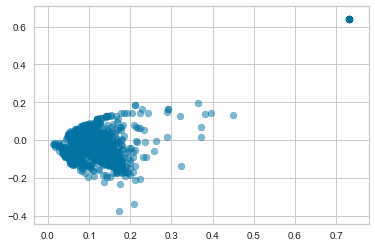

In [6]:
plt.scatter(tfidf_doc_topic[0][:,0],tfidf_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -30, 10])

Investigating the interesting result above seemed  to show that the points in the upper right had longer snippets.  So, I decided to see if there was a relationship with the number of sentences with love in it:

Matplotlib colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

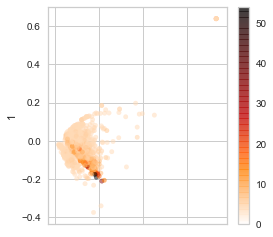

In [7]:
df=pd.DataFrame(tfidf_doc_topic[0])
df.plot.scatter(x=0,y=1,figsize=(4,4), alpha=0.5,\
               c=love_snippets.n_love_sents+3, cmap=plt.get_cmap('gist_heat_r'),vmin=0);

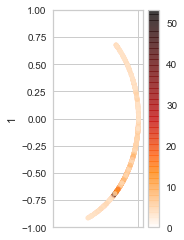

In [8]:
df = pd.DataFrame(normalize(tfidf_doc_topic[0]))
df.plot.scatter(x=0,y=1,figsize=(2,4), alpha=0.5,\
               c=love_snippets.n_love_sents+2, cmap=plt.get_cmap('gist_heat_r'),vmin=0)
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

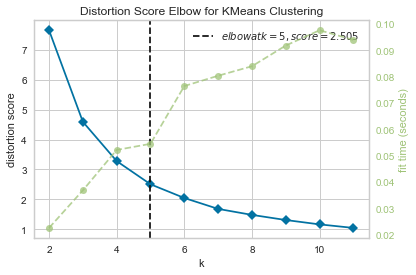

In [9]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(tfidf_doc_topic[0])        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

In [10]:
visualizer.elbow_value_

5

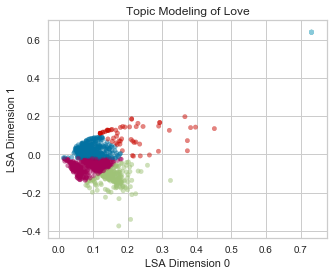

In [11]:
df=pd.DataFrame(tfidf_doc_topic[0],columns=['LSA Dimension 0','LSA Dimension 1'])
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=None,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x='LSA Dimension 0',y='LSA Dimension 1',\
                figsize=(5,4), c=col, alpha = 0.5,title='Topic Modeling of Love');
# plt.axis([-1,1.05,-1,1]);

In [12]:
for i,center in enumerate(km.cluster_centers_):
    print(cmap[i],center)

r [0.20929487 0.10159917]
g [ 0.15551667 -0.12251621]
b [0.09420929 0.01633742]
c [0.73172796 0.63893545]
m [ 0.09430543 -0.05938941]


Getting the matrix of euclidean distances from the cluster centers: (used to work that out)

In [13]:
pd.DataFrame(pairwise_distances(km.cluster_centers_,tfidf_doc_topic[0]).T).head()

,0,1,2,3,4
0,0.190005,0.045700,0.107602,0.925267,0.055293
1,0.139948,0.094579,0.076289,0.880796,0.069545
2,0.110633,0.158742,0.032869,0.859285,0.096443
3,0.207062,0.065788,0.095482,0.951308,0.022671
4,0.271654,0.055702,0.206929,0.974967,0.143027


Show the snippets from the 4 (euclidean distance) closest documents:

In [14]:
doc_topic = tfidf_doc_topic[0]
euclidean_distances_to_centers=pd.DataFrame(pairwise_distances(km.cluster_centers_,doc_topic).T)
for i,center in enumerate(km.cluster_centers_):
    n_closest=euclidean_distances_to_centers[i].nsmallest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in n_closest.iteritems():
#         print(j,cs)
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.20929487 0.10159917] color= r
129 : [0.20940512 0.07811335] I love that kind of stuff.
665 : [0.21408652 0.06961098] Let's say you're in love.
1116 : [0.1822398  0.08127166] And I thought: I love this country.
119 : [0.22342947 0.06449228] (Laughter) So that's true love, right there.


Cluster centered at: [ 0.15551667 -0.12251621] color= g
366 : [ 0.15423865 -0.12231057] "(Laughter)So I'm a researcher-storyteller, and I'm going to talk to you today — we're talking about expanding perception — and so I want to talk to you and tell some stories about a piece of my research that fundamentally expanded my perception and really actually changed the way that I live and love and work and parent. D. in social work, so my entire academic career was surrounded by people who kind of believed in the "life's messy, love it. " Well, apparently this is the way my work went as well, because, when you ask people about love, they tell you about heartbreak. I wrote a book, I publ

I'll now project the doc_topic values onto the unit circle, sphere, hypersphere I.  If I don't re-cluster yet, I'm looking at the clustering results from above:

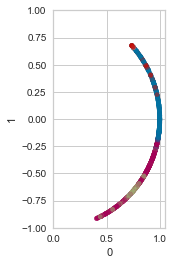

In [15]:
df = pd.DataFrame(normalize(doc_topic))
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

This next cell identifies the documents closest to the cluster centers using cosine similarity.

In [16]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=doc_topic).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.20929487 0.10159917] color= r
537 : [0.07882741 0.03864826] We love back-of-envelope calculations. I love renewables. (Laughter)So here's a summary so far: All renewables, much as I love them, are diffuse.
370 : [0.0888265  0.04256206] We're all "I Love Lucy" on a great assembly line of information, and we can't keep up.
953 : [0.12223359 0.06042369] But I love it for a totally different reason.
642 : [0.09654696 0.04830129] When I made love with my wife, I had no sperm that came out of me; I had blood.


Cluster centered at: [ 0.15551667 -0.12251621] color= g
939 : [ 0.15031723 -0.11856939] I work a lot, very hard, and I love it. I love working. I just know that I'm not built for failure, and I just know that I love the hum. I love working, right? I love that hum. So what do you do when the thing you do, the work you love, starts to taste like dust?Now, I know somebody's out there thinking, "Cry me a river, stupid writer titan lady. "(Laughter)But you know, you

Now clustering on the 

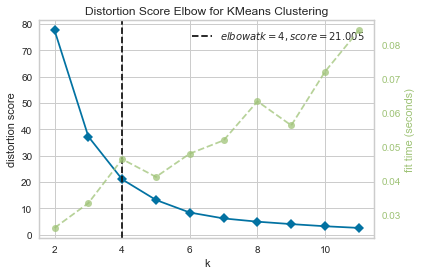

In [17]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

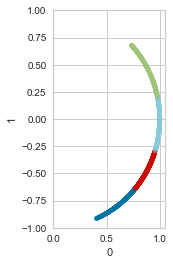

In [18]:
df = pd.DataFrame(normalize(doc_topic))
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

In [19]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.86645994 -0.48616753] color= r
51 : [ 0.87227269 -0.48901979] I love that Leilei said that the way of helping those who are suffering badly on the physical plane or on other planes is having a good time, doing it by having a good time. It's really lovely.
238 : [ 0.87189651 -0.48969019] And it's not just going to happen because a spirit of love wafts us down. It's in his book "The Four Loves. " He said that he distinguished between erotic love, when two people gaze, spellbound, into each other's eyes. We don't have to fall in love with each other, but we can become friends.
883 : [ 0.87240023 -0.48879223] In your book, you mention another story of another victim who actually got taken on by a reputation management firm, and by creating blogs and posting nice, innocuous stories about her love for cats and holidays and stuff, managed to get the story off the first couple pages of Google results, but it didn't last long. We were chatting and it was lovely and nice

# The 3-topic Result

In [20]:
display_topics(tfidf_lsa[1], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, just, laughter, like, things, thing, think, going, said, ve

Topic  1
love, picture, dearly, complexity, jc, vodka, wires, puzzle, mythology, thirds, labor, imagining, phrase, action

Topic  2
loved, really, love, ones, family, place, concert, machine, told, cook, big, iphone, sailing, lost


In [21]:
tfidf_doc_topic[1]

array([[ 0.14646278, -0.07807396,  0.03539746],
       [ 0.15634877, -0.02737484, -0.05156088],
       [ 0.12265022,  0.03343745, -0.00896773],
       ...,
       [ 0.1130815 ,  0.03989435, -0.01192055],
       [ 0.09657681, -0.0230192 , -0.06270365],
       [ 0.13771145,  0.0259288 , -0.01500992]])

In [22]:
from mpl_toolkits.mplot3d import Axes3D

In [23]:
# Use this to visualize the un-projected doc-topic space:
# df = pd.DataFrame(cv_doc_topic[1])
# Use this to visualize the projected doc-topic space:
df = pd.DataFrame(normalize(tfidf_doc_topic[1]))

Helpful in getting started with 3D plotting:
* https://pythonprogramming.net/3d-graphing-pandas-matplotlib/
* https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py
* https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

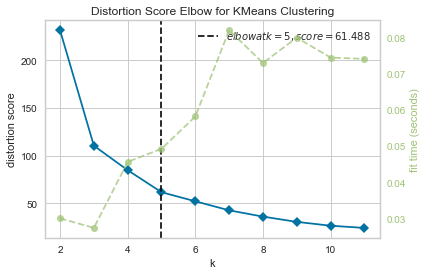

In [24]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [25]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


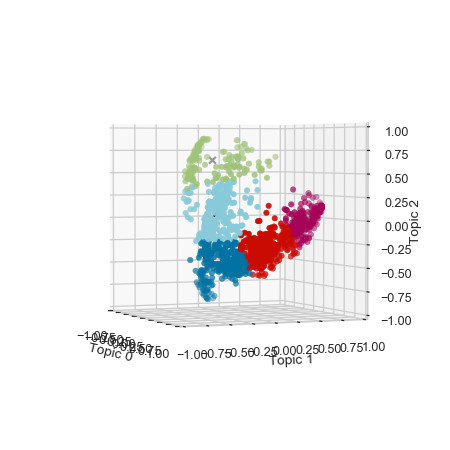

In [28]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

So, what do the clusters mean?

In [29]:
doc_topic = tfidf_doc_topic[1]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.93950984 -0.06208896 -0.27417234] color= r
559 : [ 0.95602804 -0.07168268 -0.28437998] I love to collect things. Now, it's no secret, because I like collecting things, that I love the Natural History Museum and the collections of animals at the Natural History Museum in dioramas.
788 : [ 0.95736991 -0.07630444 -0.27860454] I love my brain. I train by saying yes to whatever comes my way: drama, comedy, tragedy, love, death, losses. And I train by trying to stay in love.
177 : [ 0.96228799 -0.06004838 -0.26532247] And I said, well, that's fine; I just would love to have your input on this film and this book, and he finally agreed to it.
9 : [ 0.95387276 -0.05976191 -0.29420277] (Laughter) And Samir, on the other hand, was also quite an interesting character for the Arab world to see, because it brought out the complexities of this love-hate relationship that the Arab world has with the West.


Cluster centered at: [ 0.50868896 -0.47390875  0.6467095 ] color= g
56

## DBSCAN Clustering

In [30]:
from sklearn.cluster import DBSCAN

In [31]:
db = DBSCAN(eps=0.055, min_samples=5).fit(df)
labels = db.labels_
np.unique(labels,return_counts=True)
# labels = hdbscan.HDBSCAN(
#     min_samples=10,
#     min_cluster_size=500,
# ).fit_predict(clusterable_embedding)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 96, 868,  31,   4,  29,   9,  14,  62,  10,   5,   7,   7]))

In [32]:
cmap = {-1: 'k', 0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow',10:'fuchsia',11:'purple',12:'brown'}
col = pd.DataFrame(np.array([db.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


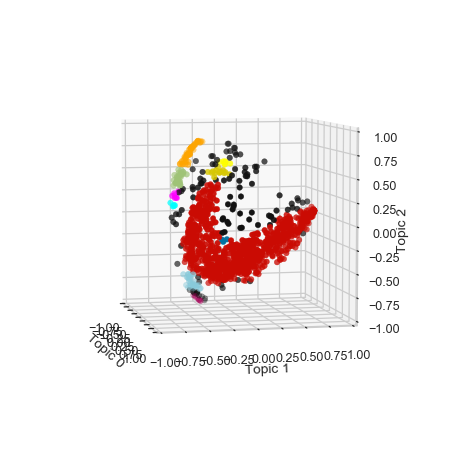

In [33]:
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

## MeanShift Clustering

In [34]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [35]:
# estimate bandwidth for mean shift
bandwidth = estimate_bandwidth(df, quantile=0.09)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(df)
cluster_centers = ms.cluster_centers_
np.unique(ms.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([395, 205, 195, 145,  52,  56,  94]))

<IPython.core.display.Javascript object>


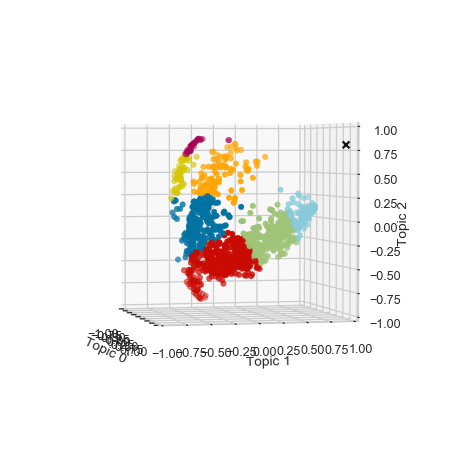

In [36]:
col = pd.DataFrame(np.array([ms.labels_])).transpose()[0].map(cmap)
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

## Hierarchical clustering

In [37]:
from sklearn.cluster import AgglomerativeClustering

In [38]:
# linkage can be 'ward', 'average' or 'complete'
hc = AgglomerativeClustering(linkage='average', n_clusters=6)
hc.fit(df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=6,
                        pooling_func='deprecated')

<IPython.core.display.Javascript object>


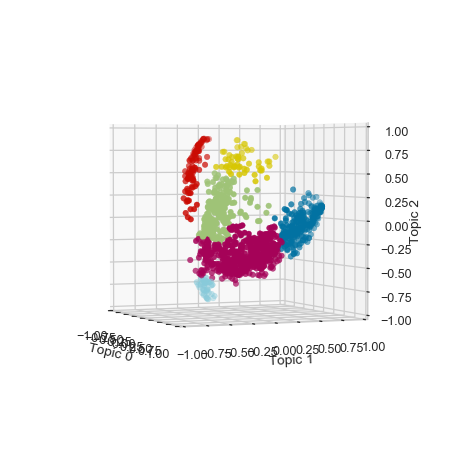

In [39]:
col = pd.DataFrame(np.array([hc.labels_])).transpose()[0].map(cmap)
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

## Spectral Clustering

In [49]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=6)
labels = sc.fit_predict(df)

<IPython.core.display.Javascript object>


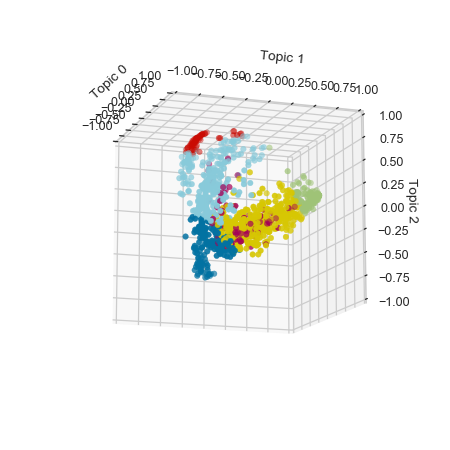

In [50]:
col = pd.DataFrame(np.array([labels])).transpose()[0].map(cmap)
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

In [42]:
display_topics(tfidf_lsa[2], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, just, laughter, like, things, thing, think, going, said, ve

Topic  1
love, picture, dearly, complexity, jc, mythology, thirds, wires, puzzle, vodka, labor, imagining, phrase, action

Topic  2
loved, really, love, ones, family, place, concert, machine, told, big, cook, iphone, sailing, detached

Topic  3
laughter, picture, lovely, right, loved, applause, told, internet, make, got, does, basically, little, true


In [51]:
doc_topic = tfidf_doc_topic[2]
df = pd.DataFrame(normalize(tfidf_doc_topic[2]))

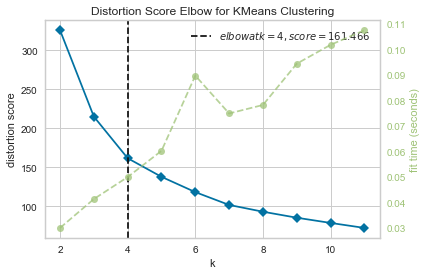

In [52]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [53]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


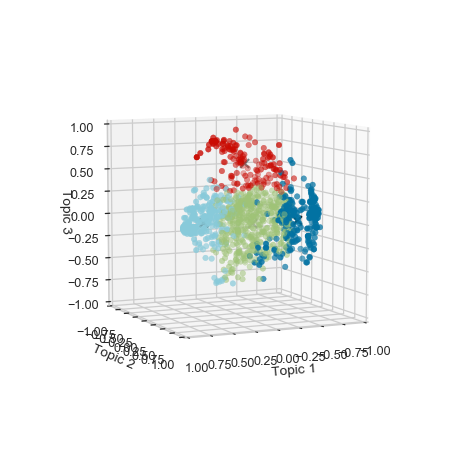

In [55]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[1],cluster_centers[2],cluster_centers[3],\
           marker='x',s=50,c='k')
ax.scatter(df[1],df[2],df[3],c=col)
ax.set_xlabel('Topic 1')
ax.set_ylabel('Topic 2')
ax.set_zlabel('Topic 3')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

In [47]:
doc_topic = tfidf_doc_topic[2]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.61718149 -0.21849529 -0.23313641  0.57975705] color= r
552 : [ 0.68389765 -0.24239927 -0.29785265  0.62033088] So one of the features that I think is important about our work is that our hardware, on top of being made with love in Italy — as you can see from the back of the circuit — (Laughter) is that it's open, so we publish all the design files for the circuit online, so you can download it and you can actually use it to make something, or to modify, to learn.
1028 : [ 0.65494799 -0.22268425 -0.25087145  0.67713984] I love what I do, but I love my kids more. "(Laughter)So my activation button for gay equality was pressed, and along with many, many others, I campaigned for years for gay rights, and in particular, the right to marry the person that I love. And in 2014, on the day that the law was changed, I married my wife, who I love very much, indeed. Love triumphs. I love to gather inspirational stories from the past and pass them on.
985 : [ 0.65570715 -0.